# Import

In [1]:
import sys
sys.path.append("..")

from src.data import CrossSimilarityDataset
from src.utils import plot_cross_similarity
from src.transforms import RandomJumps
from src.asap import load_annotations, ASAPWrapper
from src.dcnn import DCNN
from src.trainer import Trainer

import os
from tqdm import tqdm

import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision.transforms.v2 import Resize
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings

warnings.simplefilter('ignore')

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Load dataset

In [4]:
# Path to the clonned ASAP repository

asap_dir = "../../asap-dataset"

In [5]:
asap_wrapper = ASAPWrapper(asap_dir, val_ratio=0.2, random_seed=42)

In [6]:
print(f'Number of performances in train: {len(asap_wrapper.train_paths)}')
print(f'Number of performances in val: {len(asap_wrapper.val_paths)}')

Number of performances in train: 859
Number of performances in val: 177


In [7]:
img_size = 256
fs = 10 # Sampling frequency
transform = Resize((img_size, img_size))
min_num_jumps = 1
max_num_jumps = 1
jumps_transform = RandomJumps(fs, min_num_jumps=min_num_jumps, max_num_jumps=max_num_jumps, max_silence_s=8.)

train_dataset = CrossSimilarityDataset(asap_wrapper.train_paths,
                                       fs,
                                       transform,
                                       structural_transform=jumps_transform,
                                       inference_only=False)

val_dataset = CrossSimilarityDataset(asap_wrapper.val_paths,
                                     fs,
                                     transform,
                                     structural_transform=jumps_transform,
                                     inference_only=False)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

torch.Size([32, 1, 256, 256])
torch.Size([32, 2, 2])


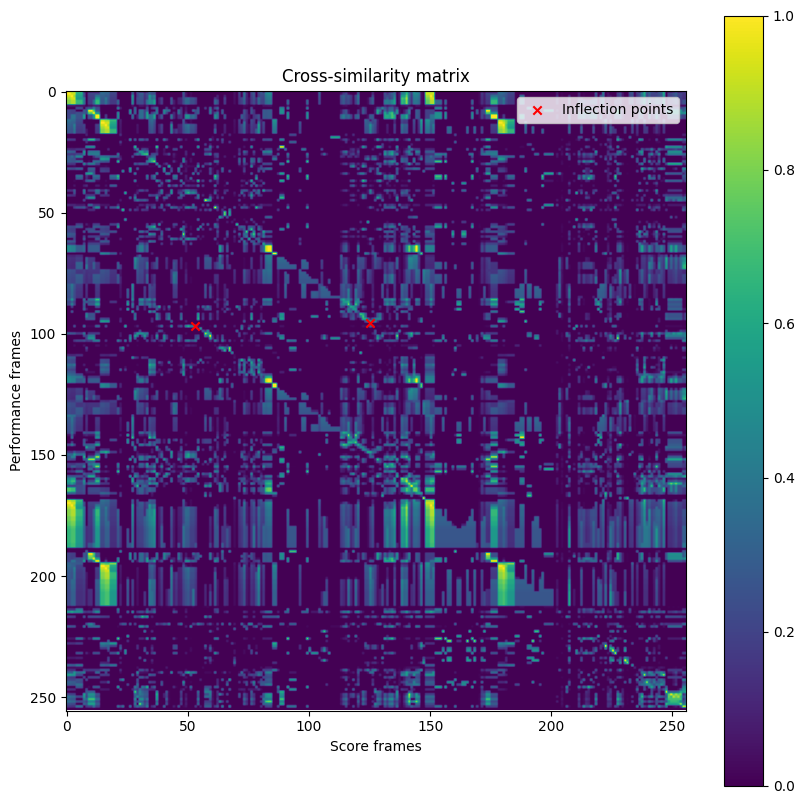

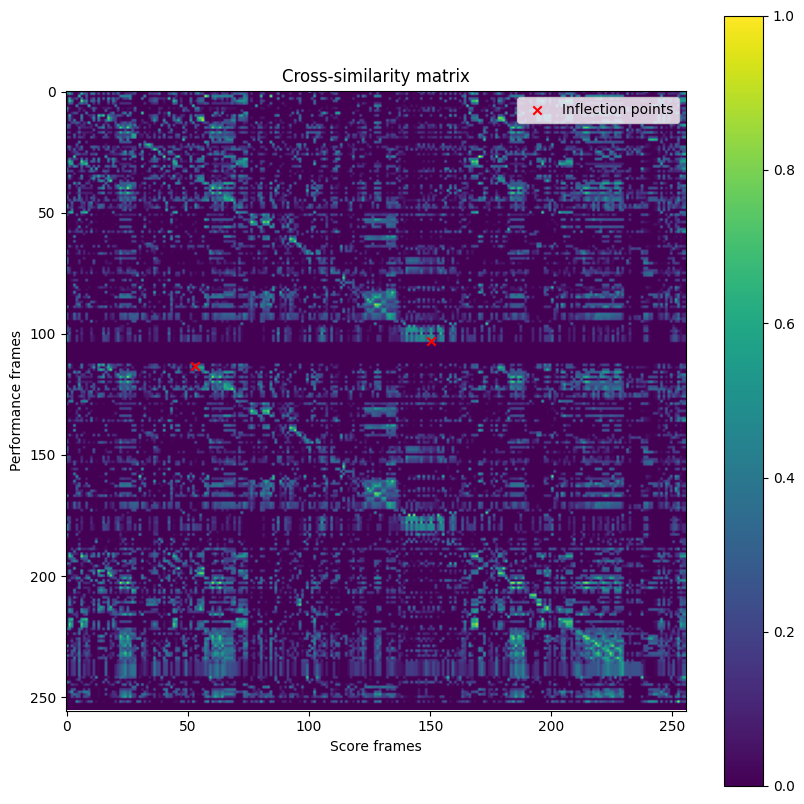

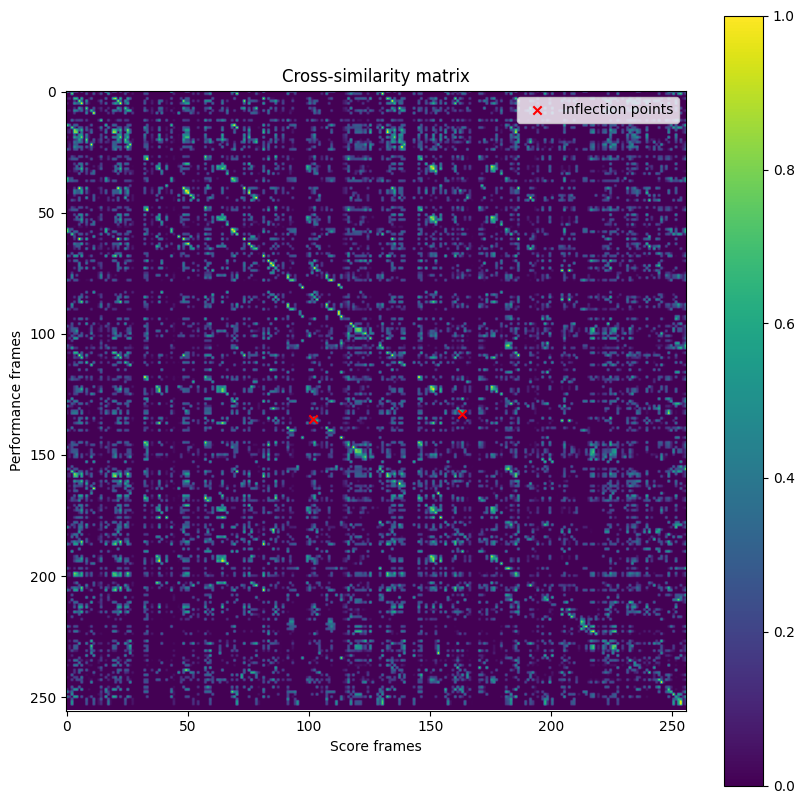

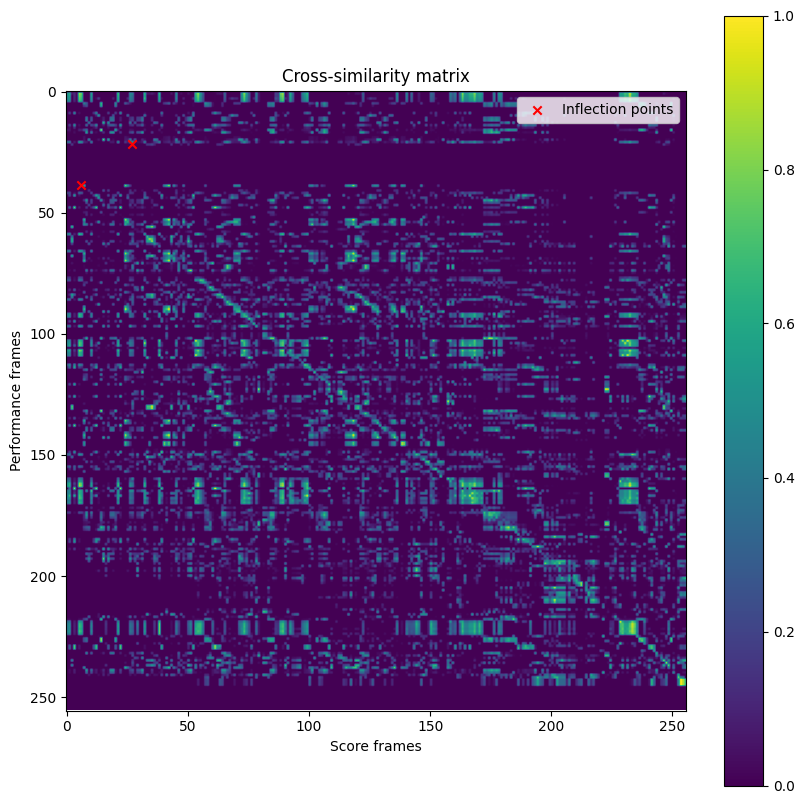

In [9]:
for batch in train_loader:
    x = batch['image']
    target = batch['target']
    for i in range(4):
        plot_cross_similarity(x[i],
                              beat_alignment=None,
                              inflection_points=target[i])
    print(x.shape)
    print(target.shape)
    break

# Model

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
model = DCNN(img_size, [16, 32, 64], max_num_jumps * 2).to(device)

In [12]:
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=1e-3)

num_epochs = 10

In [13]:
trainer = Trainer(train_loader,
                  val_loader,
                  num_epochs,
                  optimizer,
                  device)

In [14]:
trainer.train(model)

100%|██████████| 27/27 [02:08<00:00,  4.77s/it]


Epoch: 0, Train loss: 5.378954857587814


100%|██████████| 6/6 [00:34<00:00,  5.76s/it]


Epoch: 0, Val loss: 1.3174071162939072


100%|██████████| 27/27 [02:09<00:00,  4.80s/it]


Epoch: 1, Train loss: 5.546825364232063


100%|██████████| 6/6 [00:34<00:00,  5.71s/it]


Epoch: 1, Val loss: 1.168249025940895


100%|██████████| 27/27 [02:11<00:00,  4.86s/it]


Epoch: 2, Train loss: 5.573320031166077


100%|██████████| 6/6 [00:33<00:00,  5.64s/it]


Epoch: 2, Val loss: 1.3656002134084702


100%|██████████| 27/27 [02:09<00:00,  4.81s/it]


Epoch: 3, Train loss: 5.3324908167123795


100%|██████████| 6/6 [00:35<00:00,  5.83s/it]


Epoch: 3, Val loss: 1.1392223536968231


100%|██████████| 27/27 [02:12<00:00,  4.89s/it]


Epoch: 4, Train loss: 5.303464695811272


100%|██████████| 6/6 [00:34<00:00,  5.67s/it]


Epoch: 4, Val loss: 1.1920301467180252


100%|██████████| 27/27 [02:17<00:00,  5.09s/it]


Epoch: 5, Train loss: 5.461252897977829


100%|██████████| 6/6 [00:34<00:00,  5.72s/it]


Epoch: 5, Val loss: 1.2414535731077194


100%|██████████| 27/27 [02:05<00:00,  4.63s/it]


Epoch: 6, Train loss: 5.553502768278122


100%|██████████| 6/6 [00:33<00:00,  5.62s/it]


Epoch: 6, Val loss: 1.1527114808559418


100%|██████████| 27/27 [02:07<00:00,  4.72s/it]


Epoch: 7, Train loss: 5.371197581291199


100%|██████████| 6/6 [00:34<00:00,  5.80s/it]


Epoch: 7, Val loss: 1.2879911959171295


100%|██████████| 27/27 [02:10<00:00,  4.83s/it]


Epoch: 8, Train loss: 5.57678909599781


100%|██████████| 6/6 [00:34<00:00,  5.73s/it]


Epoch: 8, Val loss: 1.2815599292516708


100%|██████████| 27/27 [02:12<00:00,  4.91s/it]


Epoch: 9, Train loss: 5.510338738560677


100%|██████████| 6/6 [00:34<00:00,  5.82s/it]

Epoch: 9, Val loss: 1.2409859150648117


torch.Size([32, 1, 256, 256])
torch.Size([32, 2, 2])


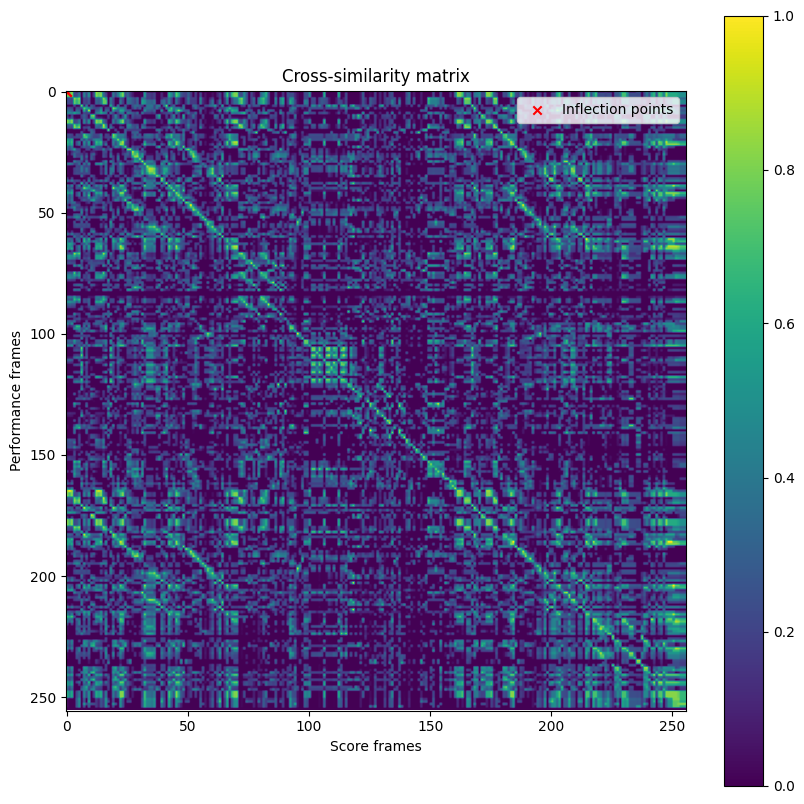

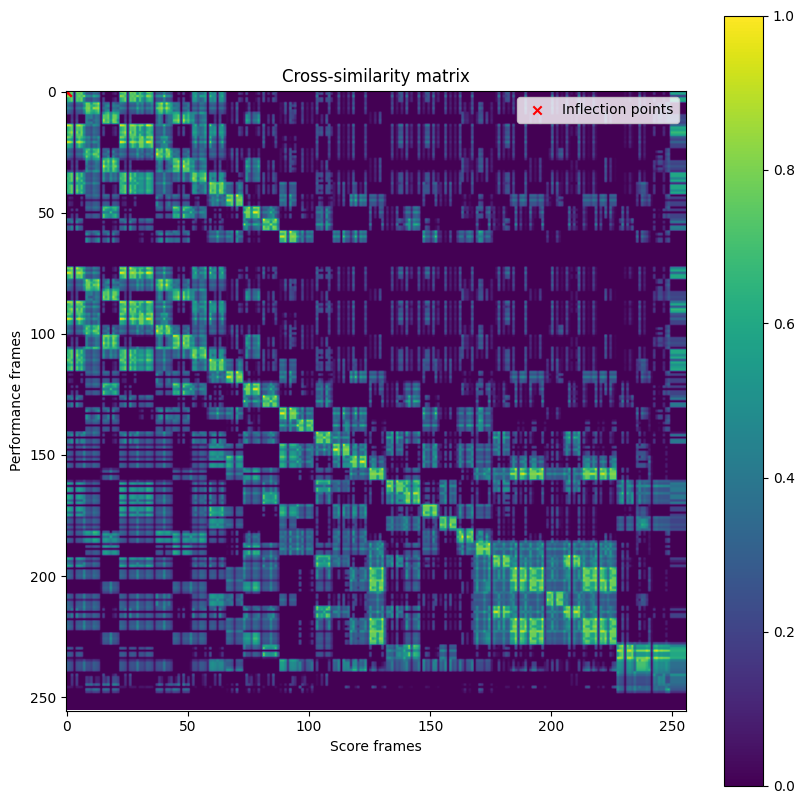

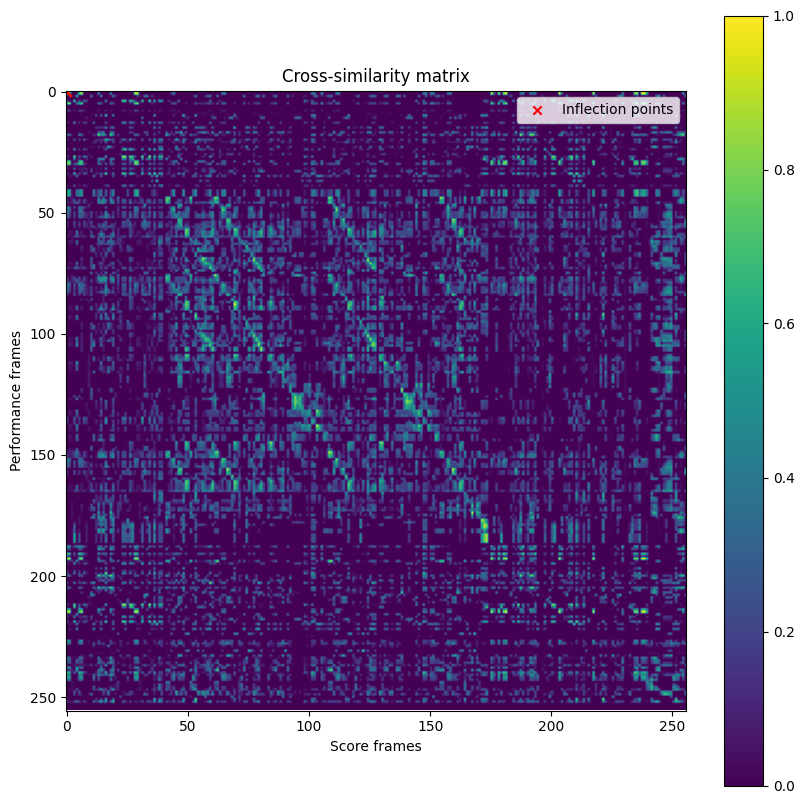

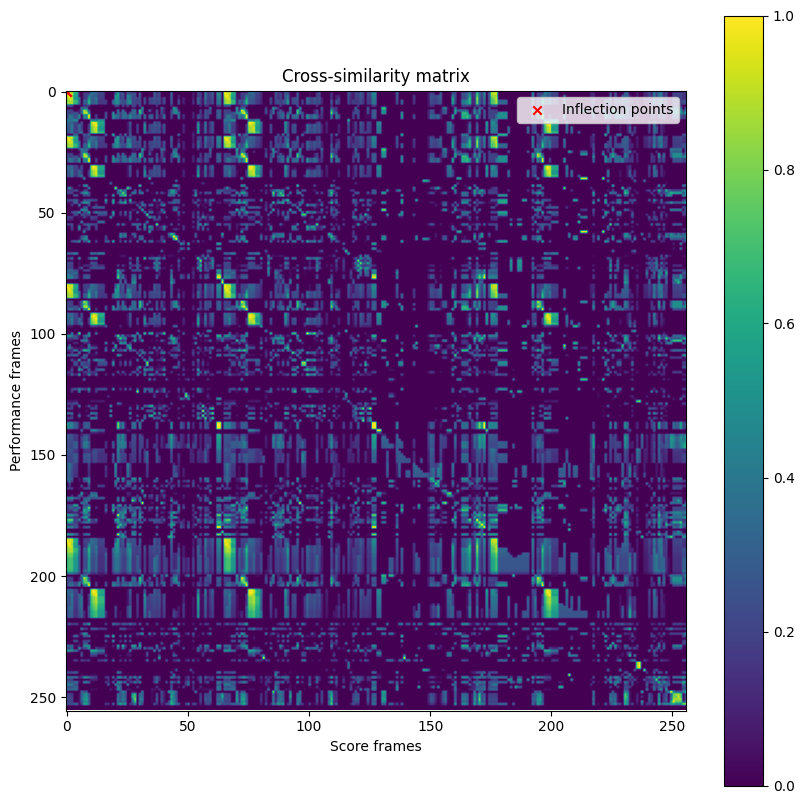

In [18]:
for batch in train_loader:
    x = batch['image'].to(device)
    y_true = batch['target'].to(device)
    model.eval()
    with torch.no_grad():
        y_pred = model(x).cpu()
    x = x.cpu()
    for i in range(4):
        plot_cross_similarity(x[i],
                              beat_alignment=None,
                              inflection_points=y_pred[i])
    print(x.shape)
    print(target.shape)
    break

In [19]:
y_pred

tensor([[[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],



In [20]:
y_true

tensor([[[0.3225, 0.3459],
         [0.3337, 0.3140]],

        [[0.2397, 0.3648],
         [0.2849, 0.0000]],

        [[0.0234, 0.0258],
         [0.0333, 0.0258]],

        [[0.0722, 0.0624],
         [0.0749, 0.0028]],

        [[0.4664, 0.8087],
         [0.5083, 0.1823]],

        [[0.2635, 0.2935],
         [0.2675, 0.2173]],

        [[0.5701, 0.8926],
         [0.5729, 0.3430]],

        [[0.3600, 0.3623],
         [0.3645, 0.3169]],

        [[0.4939, 0.5911],
         [0.5081, 0.3342]],

        [[0.4379, 0.6768],
         [0.4396, 0.1221]],

        [[0.2770, 0.3290],
         [0.2802, 0.1594]],

        [[0.4543, 0.8073],
         [0.4590, 0.0468]],

        [[0.6190, 0.8884],
         [0.6353, 0.5182]],

        [[0.3034, 0.5083],
         [0.3077, 0.0393]],

        [[0.5737, 0.7792],
         [0.5975, 0.4829]],

        [[0.2485, 0.3004],
         [0.2672, 0.1376]],

        [[0.4557, 0.8228],
         [0.4663, 0.0676]],

        [[0.2400, 0.2678],
         [0.2488, 0.1